mode,seed,volatility,average_retention
Restricted Weighted Random Load Balancer,0,0.101,0.878
Restricted Weighted Random Load Balancer,1,0.086,0.878
Restricted Weighted Random Load Balancer,2,0.083,0.878
Restricted Weighted Random Load Balancer,3,0.087,0.879
Restricted Weighted Random Load Balancer,4,0.102,0.881
Restricted Weighted Random Load Balancer,5,0.083,0.879
Restricted Weighted Random Load Balancer,6,0.11,0.881
Restricted Weighted Random Load Balancer,7,0.088,0.88
Restricted Weighted Random Load Balancer,8,0.08,0.88
Restricted Weighted Random Load Balancer,9,0.095,0.881
Restricted Weighted Random Load Balancer,10,0.086,0.88
Restricted Weighted Random Load Balancer,11,0.083,0.88
Restricted Weighted Random Load Balancer,12,0.092,0.879
Restricted Weighted Random Load Balancer,13,0.091,0.879
Restricted Weighted Random Load Balancer,14,0.093,0.88
Restricted Weighted Random Load Balancer,15,0.098,0.88
Restricted Weighted Random Load Balancer,16,0.088,0.878
Restricted Weighted Random 

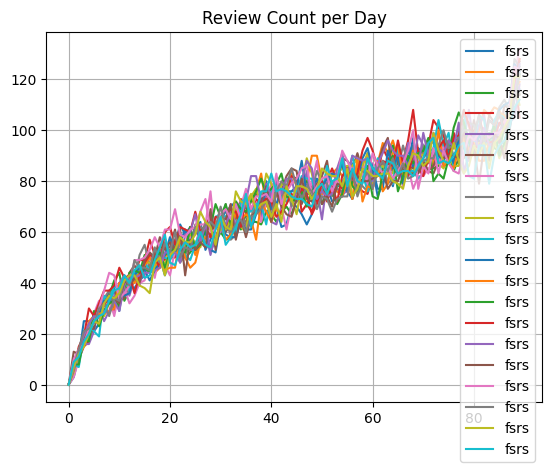

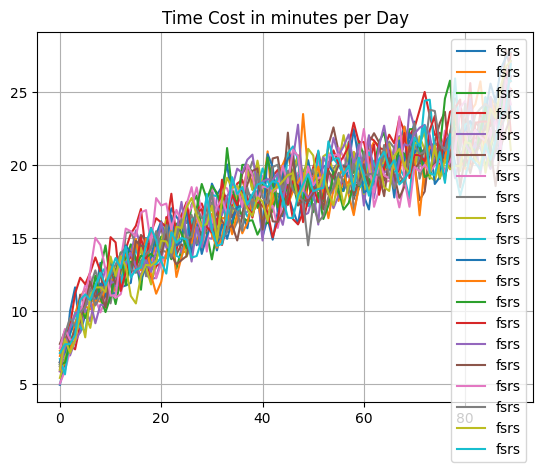

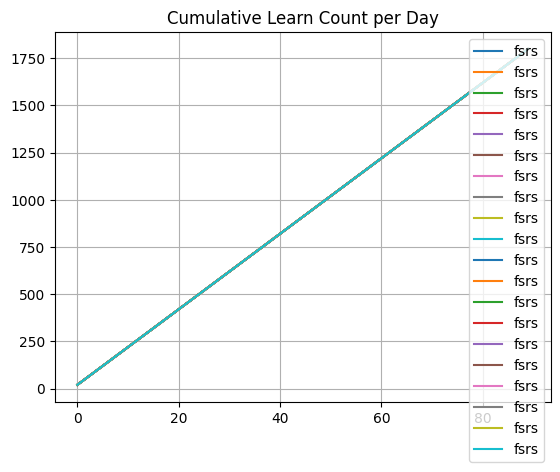

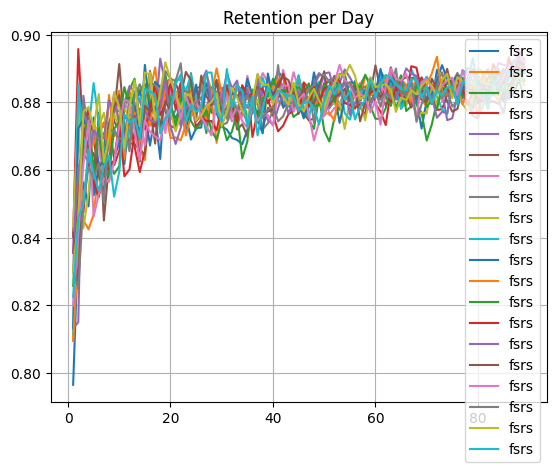

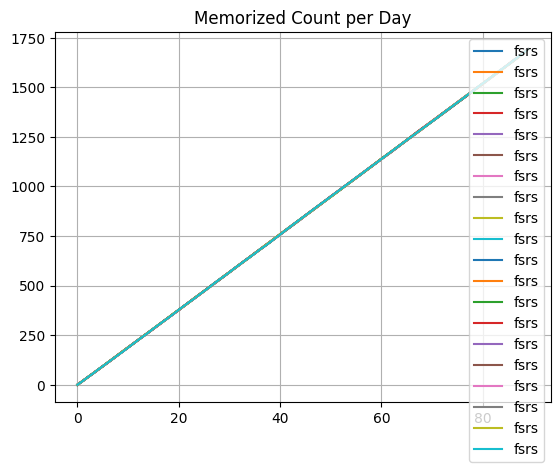

In [1]:
from fsrs_optimizer import (
    next_interval,
    power_forgetting_curve,
    lineToTensor,
    FSRS,
    DEFAULT_PARAMETER,
)
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

enable_load_balance = True
random_load_balance = True # only works when enable_load_balance is True
restrict_random = True # only works when random_load_balance is True

requestRetention = 0.9
# parameters for Anki
graduatingInterval = 1
easyInterval = 4
easyBonus = 1.3
hardInterval = 1.2
intervalModifier = 1
newInterval = 0
minimumInterval = 1
leechThreshold = 8
leechSuspend = False

# common parameters
maximumInterval = 36500
new_cards_limits = 20
review_limits = 400
max_time_limts = 10000
learn_days = 90
deck_size = 2000


FUZZ_RANGES = [
    {
        "start": 2.5,
        "end": 7.0,
        "factor": 0.15,
    },
    {
        "start": 7.0,
        "end": 20.0,
        "factor": 0.1,
    },
    {
        "start": 20.0,
        "end": np.inf,
        "factor": 0.05,
    },
]


def get_fuzz_range(interval):
    delta = 1.0
    for range in FUZZ_RANGES:
        delta += range["factor"] * max(
            min(interval, range["end"]) - range["start"], 0.0
        )
    min_ivl = int(round(interval - delta))
    max_ivl = int(round(interval + delta))
    min_ivl = max(2, min_ivl)
    min_ivl = min(min_ivl, max_ivl)
    return min_ivl, max_ivl

def load_balance(card, delta_t, today):
    if delta_t < 2.5 or not enable_load_balance:
        return delta_t
    min_ivl, max_ivl = get_fuzz_range(delta_t)
    possible_intervals = np.array(range(min_ivl, max_ivl + 1))
    review_cnts = np.array([card[card["due"] == today + i].shape[0] for i in possible_intervals])
    if random_load_balance:
        if restrict_random:
            N = max(int(np.floor(len(possible_intervals) / 2)), 2)  # N days with the lowest due count
            sorter = np.argsort(review_cnts)  # sort by review counts
            sorted_counts = review_cnts[sorter]
            sorted_intervals = possible_intervals[sorter]
            possible_intervals = sorted_intervals[:N]
            inv = [1 if r == 0 else 1/r for r in sorted_counts[:N]]
            delta_t = random.choices(possible_intervals, weights=inv)[0]
        else:
            inv = [1 if r == 0 else 1/r  for r in review_cnts]
            delta_t = random.choices(possible_intervals, weights=inv)[0]
    else:
        delta_t = possible_intervals[np.argmin(review_cnts)]
    return delta_t


first_rating_prob = np.array([0.24, 0.094, 0.495, 0.171])
review_rating_prob = np.array([0.224, 0.631, 0.145])
review_costs = np.array([23.0, 11.68, 7.33, 5.6])
learn_costs = np.array([33.79, 24.3, 13.68, 6.5])


def generate_rating(review_type):
    if review_type == "new":
        return np.random.choice([1, 2, 3, 4], p=first_rating_prob)
    elif review_type == "recall":
        return np.random.choice([2, 3, 4], p=review_rating_prob)

class Collection:
    def __init__(self):
        self.model = FSRS(DEFAULT_PARAMETER)
        self.model.eval()

    def states(self, t_history, r_history):
        with torch.no_grad():
            line_tensor = lineToTensor(
                list(zip([str(t_history)], [str(r_history)]))[0]
            ).unsqueeze(1)
            output_t = self.model(line_tensor)
            return output_t[-1][0]

    def next_states(self, states, t, r):
        with torch.no_grad():
            return self.model.step(torch.FloatTensor([[t, r]]), states.unsqueeze(0))[0]

    def init(self):
        t = 0
        r = generate_rating("new")
        p = round(first_rating_prob[r - 1], 2)
        new_states = self.states(t, r)
        return r, t, p, new_states


feature_list = [
    "difficulty",
    "stability",
    "retrievability",
    "delta_t",
    "reps",
    "lapses",
    "last_date",
    "due",
    "r_history",
    "t_history",
    "p_history",
    "states",
    "time",
    "factor",
]
field_map = {key: i for i, key in enumerate(feature_list)}


def fsrs_scheduler(stability):
    def constrain_interval(stability):
        if stability > 0:
            return min(
                next_interval(stability, requestRetention),
                maximumInterval,
            )
        else:
            return 1

    interval = constrain_interval(stability)
    return interval


def anki_scheduler(interval, real_interval, factor, rating):
    if factor is None:
        return (graduatingInterval, 2.5) if rating != 4 else (easyInterval, 2.5)
    delay = real_interval - interval
    again_interval = min(
        max(round(interval * newInterval * intervalModifier + 0.01), minimumInterval),
        maximumInterval,
    )
    hard_interval = min(
        max(
            round(interval * hardInterval * intervalModifier + 0.01),
            interval + 1,
            minimumInterval,
        ),
        maximumInterval,
    )
    good_interval = min(
        max(
            round((interval + delay / 2) * factor * intervalModifier + 0.01),
            hard_interval + 1,
            minimumInterval,
        ),
        maximumInterval,
    )
    easy_interval = min(
        max(
            round(real_interval * factor * intervalModifier * easyBonus + 0.01),
            good_interval + 1,
            minimumInterval,
        ),
        maximumInterval,
    )
    if rating == 1:
        return again_interval, max(factor - 0.2, 1.3)
    if rating == 2:
        return hard_interval, max(factor - 0.15, 1.3)
    if rating == 3:
        return good_interval, max(factor, 1.3)
    if rating == 4:
        return easy_interval, max(factor + 0.15, 1.3)
    return maximumInterval, factor


def scheduler(scheduler_name, fsrs_inputs, anki_inputs):
    if scheduler_name == "anki":
        return anki_scheduler(*anki_inputs)
    elif scheduler_name == "fsrs":
        return fsrs_scheduler(fsrs_inputs), 2.5
    return None

if enable_load_balance:
    if random_load_balance:
        if restrict_random:
            mode = "Restricted Weighted Random Load Balancer"
        else:
            mode = "Weighted Random Load Balancer"
    else:
        mode = "Simple Load Balancer"
else:
    mode = "No Load Balancer"

scheduler_name = "fsrs"
print(f"mode,seed,volatility,average_retention")

for seed in range(0, 20):
    new_card_per_day = np.array([0] * learn_days)
    review_card_per_day = np.array([0.0] * learn_days)
    time_per_day = np.array([0.0] * learn_days)
    learned_per_day = np.array([0.0] * learn_days)
    retention_per_day = np.array([0.0] * learn_days)
    expected_memorization_per_day = np.array([0.0] * learn_days)

    card_df = pd.DataFrame(
        np.zeros((deck_size, len(feature_list))),
        index=range(deck_size),
        columns=feature_list,
    )
    card_df["states"] = card_df["states"].astype(object)

    card_df["r_history"] = card_df["r_history"].astype(str)
    card_df["t_history"] = card_df["t_history"].astype(str)
    card_df["p_history"] = card_df["p_history"].astype(str)
    card_df["reps"] = 0
    card_df["lapses"] = 0
    card_df["due"] = learn_days

    student = Collection()
    random.seed(seed)
    np.random.seed(seed)
    for today in range(learn_days):
        reviewed = 0
        learned = 0
        review_time_today = 0
        learn_time_today = 0

        card_df["delta_t"] = today - card_df["last_date"]
        card_df["retrievability"] = power_forgetting_curve(
            card_df["delta_t"], card_df["stability"]
        )
        need_review = (
            card_df[card_df["due"] <= today]
            if leechSuspend == False
            else card_df[(card_df["due"] <= today) & (card_df["lapses"] < leechThreshold)]
        )
        retention_per_day[today] = need_review["retrievability"].mean()
        for idx in need_review.index:
            if (
                reviewed >= review_limits
                or review_time_today + learn_time_today >= max_time_limts
            ):
                break

            reviewed += 1
            last_date = card_df.iat[idx, field_map["last_date"]]
            due = card_df.iat[idx, field_map["due"]]
            factor = card_df.iat[idx, field_map["factor"]]
            card_df.iat[idx, field_map["last_date"]] = today
            ivl = card_df.iat[idx, field_map["delta_t"]]
            card_df.iat[idx, field_map["t_history"]] += f",{ivl}"

            stability = card_df.iat[idx, field_map["stability"]]
            retrievability = card_df.iat[idx, field_map["retrievability"]]
            card_df.iat[idx, field_map["p_history"]] += f",{retrievability:.2f}"
            reps = card_df.iat[idx, field_map["reps"]]
            lapses = card_df.iat[idx, field_map["lapses"]]
            states = card_df.iat[idx, field_map["states"]]

            if random.random() < retrievability:
                rating = generate_rating("recall")
                recall_time = review_costs[rating - 1]
                review_time_today += recall_time
                card_df.iat[idx, field_map["r_history"]] += f",{rating}"
                new_states = student.next_states(states, ivl, rating)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])
                card_df.iat[idx, field_map["stability"]] = new_stability
                card_df.iat[idx, field_map["difficulty"]] = new_difficulty
                card_df.iat[idx, field_map["states"]] = new_states
                card_df.iat[idx, field_map["reps"]] = reps + 1
                card_df.iat[idx, field_map["time"]] += recall_time

                delta_t, factor = scheduler(
                    scheduler_name,
                    new_stability,
                    (due - last_date, ivl, factor, rating),
                )
                delta_t = load_balance(card_df, delta_t, today)

                card_df.iat[idx, field_map["factor"]] = factor
                card_df.iat[idx, field_map["due"]] = today + delta_t

            else:
                review_time_today += review_costs[0]

                rating = 1
                card_df.iat[idx, field_map["r_history"]] += f",{rating}"

                new_states = student.next_states(states, ivl, 1)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])

                card_df.iat[idx, field_map["stability"]] = new_stability
                card_df.iat[idx, field_map["difficulty"]] = new_difficulty
                card_df.iat[idx, field_map["states"]] = new_states

                reps = 0
                lapses = lapses + 1

                card_df.iat[idx, field_map["reps"]] = reps
                card_df.iat[idx, field_map["lapses"]] = lapses

                delta_t, factor = scheduler(
                    scheduler_name,
                    new_stability,
                    (due - last_date, ivl, factor, rating),
                )
                delta_t = load_balance(card_df, delta_t, today)

                card_df.iat[idx, field_map["due"]] = today + delta_t
                card_df.iat[idx, field_map["factor"]] = factor
                card_df.iat[idx, field_map["time"]] += review_costs[0]

        need_learn = card_df[card_df["stability"] == 0]

        for idx in need_learn.index:
            if (
                learned >= new_cards_limits
                or review_time_today + learn_time_today >= max_time_limts
            ):
                break
            learned += 1
            r, t, p, new_states = student.init()
            learn_time_today += learn_costs[r - 1]
            card_df.iat[idx, field_map["last_date"]] = today

            card_df.iat[idx, field_map["reps"]] = 1
            card_df.iat[idx, field_map["lapses"]] = 0

            new_stability = float(new_states[0])
            new_difficulty = float(new_states[1])

            card_df.iat[idx, field_map["r_history"]] = str(r)
            card_df.iat[idx, field_map["t_history"]] = str(t)
            card_df.iat[idx, field_map["p_history"]] = str(p)
            card_df.iat[idx, field_map["stability"]] = new_stability
            card_df.iat[idx, field_map["difficulty"]] = new_difficulty
            card_df.iat[idx, field_map["states"]] = new_states

            delta_t, factor = scheduler(
                scheduler_name, new_stability, (None, None, None, r)
            )
            delta_t = load_balance(card_df, delta_t, today)
            card_df.iat[idx, field_map["due"]] = today + delta_t
            card_df.iat[idx, field_map["time"]] = learn_costs[r - 1]
            card_df.iat[idx, field_map["factor"]] = factor

        new_card_per_day[today] = learned
        review_card_per_day[today] = reviewed
        learned_per_day[today] = learned_per_day[today - 1] + learned
        time_per_day[today] = review_time_today + learn_time_today
        expected_memorization_per_day[today] = sum(
            card_df[card_df["retrievability"] > 0]["retrievability"]
        )

    volatility = np.mean(np.abs(np.diff(review_card_per_day)) / review_card_per_day[1:])
    average_retention = retention_per_day[1:].mean()

    total_learned = sum(new_card_per_day)
    total_time = sum(time_per_day)
    total_remembered = int(card_df["retrievability"].sum())
    total_leeches = len(card_df[card_df["lapses"] >= leechThreshold])

    plt.figure(1)
    plt.plot(review_card_per_day, label=f"{scheduler_name}")
    plt.figure(2)
    plt.plot(time_per_day / 60, label=f"{scheduler_name}")
    plt.figure(3)
    plt.plot(learned_per_day, label=f"{scheduler_name}")
    plt.figure(4)
    plt.plot(retention_per_day, label=f"{scheduler_name}")
    plt.figure(5)
    plt.plot(expected_memorization_per_day, label=f"{scheduler_name}")

    # print("scheduler:", scheduler_name)
    # print("learned cards:", total_learned)
    # print("time in minutes:", round(total_time / 60, 1))
    # print("remembered cards:", total_remembered)
    # print("time per remembered card:", round(total_time / 60 / total_remembered, 2))
    # print("leeches:", total_leeches)
    print(f"{mode},{seed},{round(volatility, 3)},{round(average_retention, 3)}")

    save = card_df[card_df["retrievability"] > 0].copy()
    save["stability"] = round(save["stability"], 2)
    save["retrievability"] = round(save["retrievability"], 2)
    save["difficulty"] = round(save["difficulty"], 2)
    save["factor"] = round(save["factor"], 2)
    save["time"] = round(save["time"], 2)

plt.figure(1)
plt.title(f"Review Count per Day")
plt.legend()
plt.grid(True)
plt.figure(2)
plt.title(f"Time Cost in minutes per Day")
plt.legend()
plt.grid(True)
plt.figure(3)
plt.title(f"Cumulative Learn Count per Day")
plt.legend()
plt.grid(True)
plt.figure(4)
plt.title("Retention per Day")
plt.legend()
plt.grid(True)
plt.figure(5)
plt.title(f"Memorized Count per Day")
plt.legend()
plt.grid(True)
plt.show()
plt.close("all")

In [2]:
import pandas as pd
from scipy import stats

data = pd.read_csv('./result.csv')

result = data.groupby('mode')['volatility'].agg(['mean', 'std'])

print("volatility mean and std:")
print(result)
print()

# 进行t检验
modes = data['mode'].unique()
n = len(modes)

print("t-test:")
for i in range(n):
    for j in range(i+1, n):
        mode1 = modes[i]
        mode2 = modes[j]
        
        group1 = data[data['mode'] == mode1]['volatility']
        group2 = data[data['mode'] == mode2]['volatility']
        
        t_stat, p_value = stats.ttest_ind(group1, group2)
        
        print(f"{mode1} vs {mode2}:")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print()


volatility mean and std:
                                             mean       std
mode                                                       
No Load Balancer                          0.13395  0.009254
Restricted Weighted Random Load Balancer  0.09020  0.007736
Simple Load Balancer                      0.08130  0.005526
Weighted Random Load Balancer             0.10735  0.009281

t-test:
No Load Balancer vs Simple Load Balancer:
t-statistic: 21.8461
p-value: 0.0000

No Load Balancer vs Weighted Random Load Balancer:
t-statistic: 9.0768
p-value: 0.0000

No Load Balancer vs Restricted Weighted Random Load Balancer:
t-statistic: 16.2214
p-value: 0.0000

Simple Load Balancer vs Weighted Random Load Balancer:
t-statistic: -10.7855
p-value: 0.0000

Simple Load Balancer vs Restricted Weighted Random Load Balancer:
t-statistic: -4.1865
p-value: 0.0002

Weighted Random Load Balancer vs Restricted Weighted Random Load Balancer:
t-statistic: 6.3478
p-value: 0.0000

